## Installs and Imports

In [2]:
%%capture
!pip install contextualized-topic-models==2.2.0

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
"""
SPECIFY BASE DIRECTORY HERE
"""

base_dir = "/content/drive/MyDrive/Thesis"

In [5]:
import sys
sys.path.append(base_dir)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from database import Database
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pandas as pd
from contextualized_topic_models.models.ctm import ZeroShotTM
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation
from contextualized_topic_models.utils.data_preparation import bert_embeddings_from_file
import nltk
import torch
import random
import numpy as np
import spacy


nltk.download("stopwords")
nlp = spacy.load('en_core_web_sm')
sns.set_theme(style="white", palette='magma')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
torch.manual_seed(10)
torch.cuda.manual_seed(10)
np.random.seed(10)
random.seed(10)
nltk.download('stopwords')
torch.backends.cudnn.enabled = False
torch.backends.cudnn.deterministic = True

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Analysis on data utilised

### Topic Themes


In [8]:
"""
Read topic themes dataset
"""

data = pd.read_excel(f"{base_dir}/data/Topic themes.xlsx")

#Get word counts for topic themes
data['count_words'] = data['Topic Category'].str.split().str.len()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


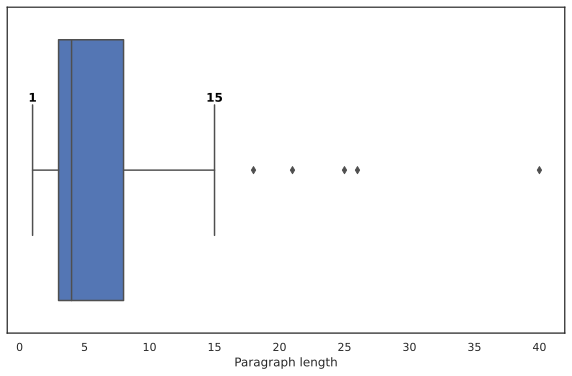

In [9]:
def box_plot_function(column,data):
    fig,ax = plt.subplots(figsize = (10,6))
    box_plot = sns.boxplot(data[column],color = '#4472c4')

    q_1 = data[column].quantile(0.25)
    q_3 = data[column].quantile(0.75)

    whiskers_upper = min(int(q_3 + 1.5*(q_3-q_1)),data[column].max())
    whiskers_lower = max(int(q_3 - 1.5*(q_3-q_1)),data[column].min())

    for ytick in box_plot.get_yticks():
        box_plot.text(whiskers_upper,ytick - 0.21,f'{whiskers_upper}', 
                horizontalalignment='center',color='black',weight='semibold')
        box_plot.text(whiskers_lower,ytick - 0.21,f'{whiskers_lower}', 
                horizontalalignment='center',color='black',weight='semibold')



    ax.set_xlabel("Paragraph length")
    ax.set_ylabel("")
    plt.show()

box_plot_function('count_words',data)

In [10]:
print("Summary Description on Topic Theme Counts\n" + "_"*50)
print()
data["count_words"].describe()

Summary Description on Topic Theme Counts
__________________________________________________



count    97.000000
mean      6.360825
std       5.897008
min       1.000000
25%       3.000000
50%       4.000000
75%       8.000000
max      40.000000
Name: count_words, dtype: float64

In [11]:
"""
Function for retrieving tfidf and count vectors of 
"""


def create_vectorizer(data ,low, high, gram_start, gram_end):
    tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                                   ngram_range=(gram_start,gram_end),
                                   min_df=low, 
                                   max_df=high, 
                                   stop_words='english', 
                                   sublinear_tf=True)
    
    vectorizer = CountVectorizer(analyzer='word',
                             ngram_range=(gram_start, gram_end),
                             min_df=low, 
                             max_df=high, 
                             stop_words='english')

    X = tfidf_vectorizer.fit_transform(data)
    X2= vectorizer.fit_transform(data)
    # create a df collecting wwords, tf, idf and tfidf
    tdifs_df = pd.DataFrame(data={'word': vectorizer.get_feature_names_out(), 
                        'tf': X2.sum(axis=0).A1, 
                        'idf': tfidf_vectorizer.idf_,
                        'tfidf': X.sum(axis=0).A1}).sort_values(['tfidf', 'tf', 'idf'])
    
    
    
    return X, tdifs_df



In [24]:
"""
Function for plot of tfidf vectors
"""
def tf_idfPlot(data,n_annotates, doc_type,multiplier = 100): 

    data = data.sort_values(by = "tfidf",ascending = False).reset_index(drop=True)
    
    fig, ax = plt.subplots(1,2, facecolor='w',figsize = (17,4))
    
    #plot beofr eand after tfidf-df graph
    data['tf']*=multiplier
    data.plot.scatter(x = "tfidf", y = "idf", s = "tf", ax = ax[0], alpha=0.3, edgecolor='k')

    
    data.iloc[:50].plot.scatter(x = "tfidf", y = "idf", s = "tf", ax = ax[1], 
                                 alpha=0.3, edgecolor='k')

    #add text for the most frequent words
    for index,row in data.iloc[0:n_annotates].iterrows():
        if row['word'] in ['water' ,'wastewater', 'supply','afforestation','agricultural', 'use']:
            color='red'
        else :
            color='black'
        
        ax[1].text(row["tfidf"],row["idf"]+index/500,
                     row["word"],horizontalalignment='left',size = "small", color = color, fontsize='xx-small')
    
    plt.show()

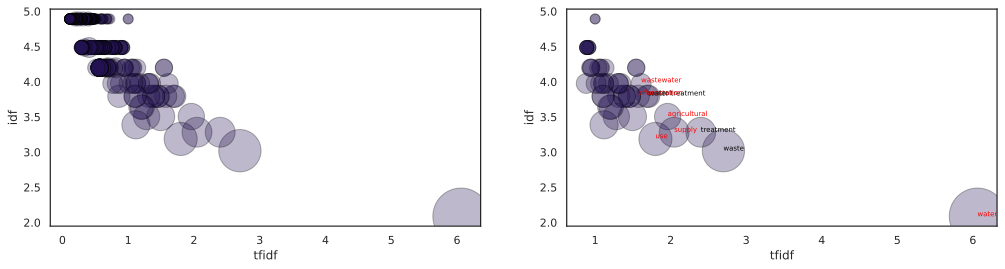

In [25]:
"""
Tfidf plots
"""
X, tdifs =create_vectorizer(data['Topic Category'], 0.01,0.9,1,3)
tf_idfPlot(tdifs,10, 'all topics')

### Complete Hypothesis Set

In [26]:
db = Database(f"{base_dir}/data/databases.db")
docs=db.query("SELECT * FROM relevant_doc")

In [27]:
"""
Filter for only correct document categories
"""
docs = docs.loc[docs['document_type'].isin(['NDC','NAPA', "NAP"])].copy()
docs['paragraph_length'] = docs['paragraph'].apply(lambda x: len(x))

In [28]:
print('Number of NAPs: ', len(docs[docs['document_type']=="NAP"]))
print('Number of NAPs: ', len(docs[docs['document_type']=="NAPA"]))
print('Number of NAPs: ', len(docs[docs['document_type']=="NDC"]))

Number of NAPs:  10507
Number of NAPs:  14702
Number of NAPs:  12247


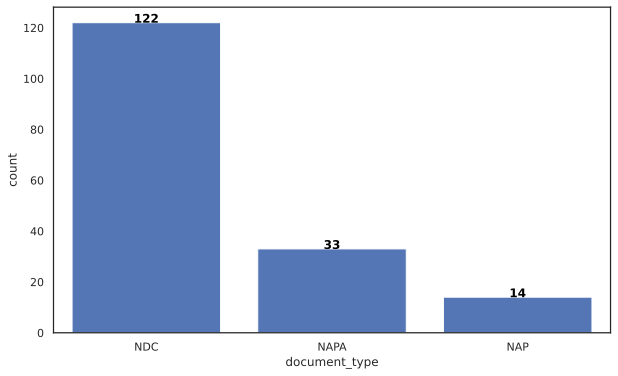

In [54]:
"""
Countplot of unique number of documents for each type
"""
uniques = docs.drop_duplicates(subset = "document_name")
fig,ax = plt.subplots(figsize = (10,6))

counts = uniques.groupby('document_type').size().sort_values(ascending = False)
halfed = counts/2
count_plot  = sns.countplot(x='document_type', data = uniques,color = "#4472c4")


for xtick in count_plot.get_xticks():

    count_plot.text(xtick,counts[xtick],f'{counts[xtick]}', 
            horizontalalignment='center',color='black',weight='semibold')
plt.show()


In [38]:
counts

document_type
NAP      14
NAPA     33
NDC     122
dtype: int64

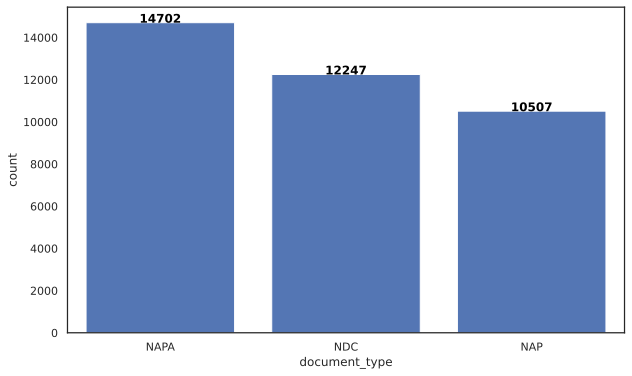

In [53]:
"""
Countplot of the number of paragraphs across each document type 
"""
fig,ax = plt.subplots(figsize = (10,6))

counts = docs.groupby('document_type').size().sort_values(ascending = False)
halfed = counts/2
count_plot  = sns.countplot(x='document_type', data = docs,color = "#4472c4", order = ["NAPA", "NDC", "NAP"])


for xtick in count_plot.get_xticks():

    count_plot.text(xtick,counts[xtick],f'{counts[xtick]}', 
            horizontalalignment='center',color='black',weight='semibold')
plt.show()

In [55]:
"""
Get paragraph length of the documents
"""
docs["paragraph_length"] = docs["paragraph"].str.split().str.len()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


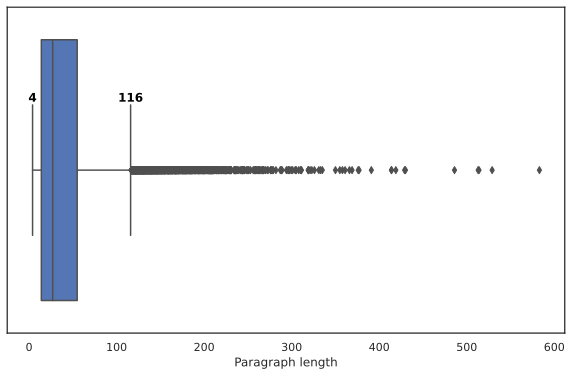

In [56]:
"""
Distribution plot of the paragraph length
"""


box_plot_function('paragraph_length',docs)


In [57]:
"""
Summary Statistics of Document Length
"""
docs['paragraph_length'].describe()

count    37456.000000
mean        40.979629
std         38.851328
min          4.000000
25%         14.000000
50%         27.000000
75%         55.000000
max        583.000000
Name: paragraph_length, dtype: float64

In [58]:
"""
Maximum document value
"""
print("Max value: ",docs['paragraph_length'].max() )

Max value:  583


0
1
2


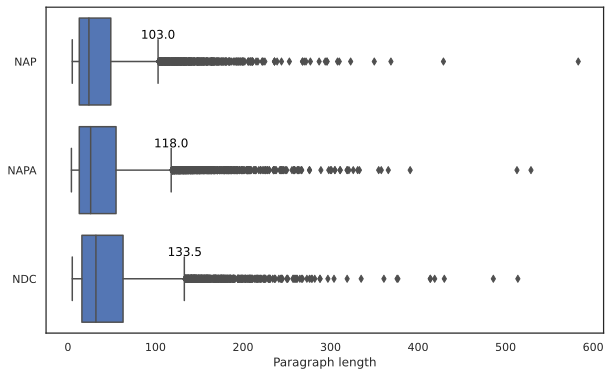

In [59]:
fig,ax = plt.subplots(figsize = (10,6))
docs = docs.sort_values(by = 'document_type')
box_plot = sns.boxplot(data = docs, x= 'paragraph_length', y= "document_type",color = '#4472c4')

q_3 = docs.groupby("document_type")['paragraph_length'].quantile(0.75)

whiskers = q_3 + 1.5*(q_3-docs.groupby("document_type")['paragraph_length'].quantile(0.25))

vertical_offset = whiskers * 0.05 # offset from median for display

for ytick in box_plot.get_yticks():
    print(ytick)
    box_plot.text(whiskers[ytick],ytick -0.21,f'{whiskers[ytick]}', 
            horizontalalignment='center',color='black',)



ax.set_xlabel("Paragraph length")
ax.set_ylabel("")
plt.show()

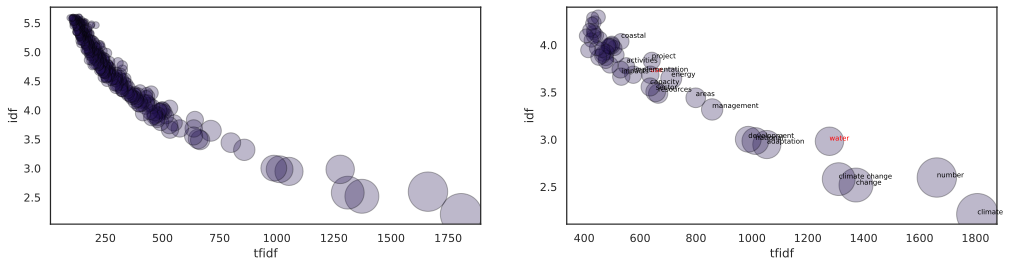

In [60]:
"""
TFIDF Plot all Paragraphs
"""
X, tdifs =create_vectorizer(docs['paragraph'], 0.01,0.7,1,3)
tf_idfPlot(tdifs,20, 'all documents',1/10)

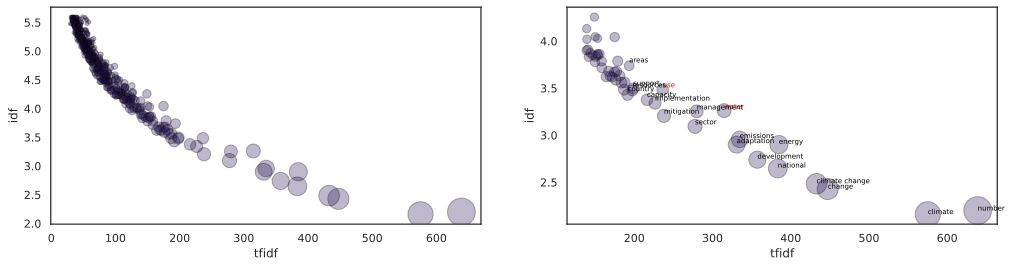

In [61]:
"""
TFIDF Plot NDCs
"""
X, tdifs =create_vectorizer(docs['paragraph'][docs['document_type']=="NDC"], 0.01,0.7,1,3)
tf_idfPlot(tdifs,20, "NDCs",1/10)

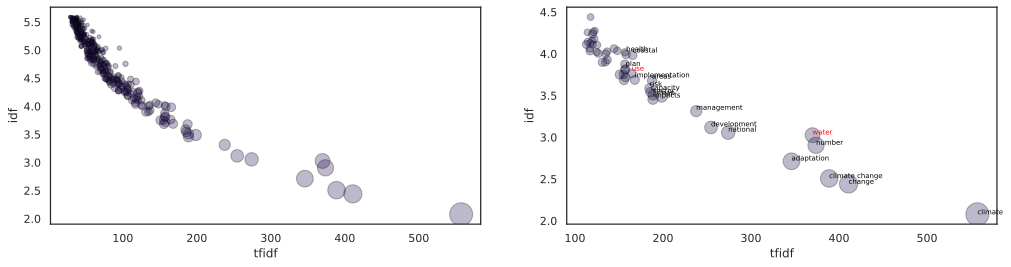

In [62]:
"""
TFIDF Plot NAPs
"""
X, tdifs =create_vectorizer(docs['paragraph'][docs['document_type']=="NAP"], 0.01,0.7,1,3)
tf_idfPlot(tdifs,20, 'NAPs',1/10)

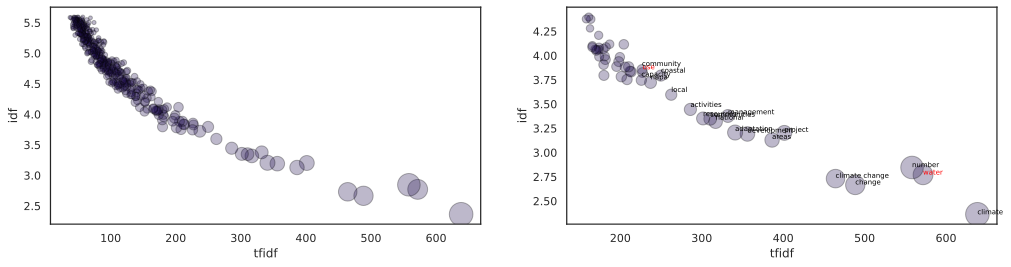

In [63]:
"""
TFIDF Plot NAPAs
"""
X, tdifs =create_vectorizer(docs['paragraph'][docs['document_type']=="NAPA"], 0.01,0.7,1,3)
tf_idfPlot(tdifs,20, 'NAPAs',1/10)

### Labelled Dataset Analysis


In [64]:
db = Database(f"{base_dir}/data/best_paragraphs.db")
labeled = db.query("SELECT * FROM ready_dataset")
labeled['word_count'] = labeled["sentences"].str.split().str.len()

In [68]:
print(0.6*len(labeled),0.2*len(labeled),len(labeled))

3192.6 1064.2 5321


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


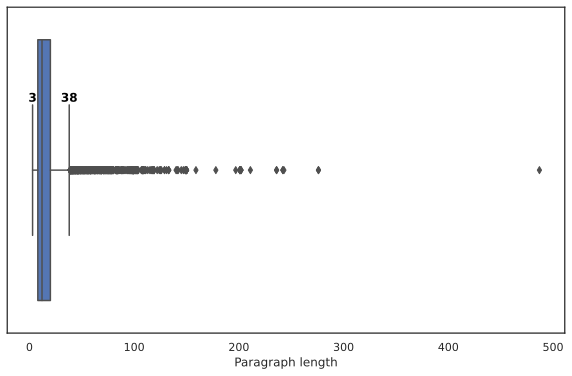

In [65]:
box_plot_function("word_count", labeled)

In [69]:
"""
Summary Statistics of Document Length
"""
labeled['word_count'].describe()

count    5321.000000
mean       19.968051
std        24.492191
min         3.000000
25%         8.000000
50%        12.000000
75%        20.000000
max       487.000000
Name: word_count, dtype: float64

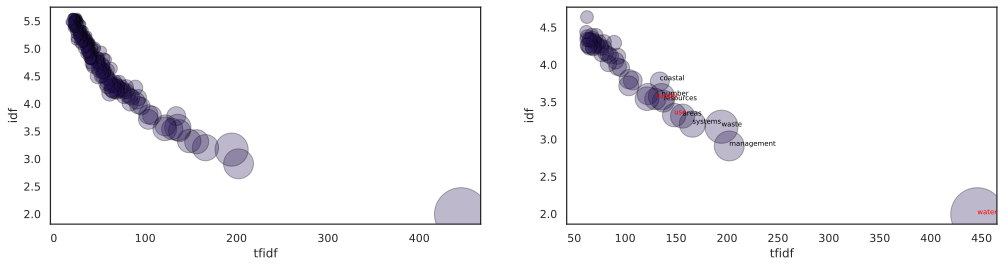

In [70]:
"""
TFIDF Plot
"""

X, tdifs =create_vectorizer(labeled['sentences'], 0.01,0.8,1,3)
tf_idfPlot(tdifs,10, 'training data',1)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


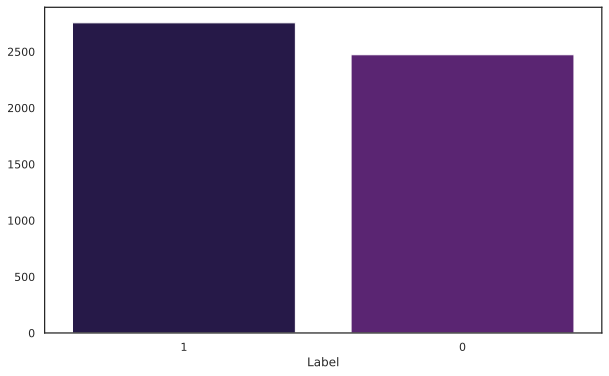

In [156]:
"""
Distribution of labels
"""

labeled = labeled.loc[labeled["label"] != "-1"]
fig,ax = plt.subplots(figsize = (10,6))

sns.countplot(labeled['label']).set(xlabel='Label', ylabel=None)
plt.show()

In [71]:
"""
Load train, test and eval dataset
"""

train = pd.read_csv(f"{base_dir}/data/train.csv")
evaluation = pd.read_csv(f"{base_dir}/data/valid.csv")
test = pd.read_csv(f"{base_dir}/data/test.csv")



In [74]:
"""
Train dataset size
"""
train.groupby("label").size()

label
0    1556
1    1901
dtype: int64

In [80]:
590/(590+506)

0.5383211678832117

In [75]:
"""
Evaluation dataset size
"""
evaluation.groupby("label").size()

label
0    476
1    619
dtype: int64

In [76]:
"""
Test dataset size
"""
test.groupby("label").size()

label
0    506
1    590
dtype: int64

###Contextualized Topic Modelling - NOT INCLUDED

In [157]:
tokens = [
    [token.text for token in nlp(sentence)] 
    for sentence in docs['paragraph'].values
]

In [158]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [159]:
from nltk.stem import WordNetLemmatizer
  
lemmatizer = WordNetLemmatizer()

stems = [
         [lemmatizer.lemmatize(token) for token in sentence] 
         for sentence in tokens
        ]

In [160]:
pos = [
    [token.pos_ for token in nlp(sentence)] 
    for sentence in docs['paragraph'].values
]

In [161]:
idx_all=[]

for sentence_pos in pos:
  idx_sentence=[]

  for idx, word_pos in enumerate(sentence_pos):
    if word_pos in ['NOUN', "ADJ", "VERB", "ADV"]:
      idx_sentence.append(idx)
    
  idx_all.append(idx_sentence)

In [162]:
fig, ax = plt.subplots(1,1, facecolor='w',figsize = (30,20))
sns.countplot([word if word in ['NOUN', 'ADJ', 'VERB'] for sentence in pos for word in sentence], ax=ax)

SyntaxError: ignored

In [ ]:
words_for_bow=[]
for index, sentence in enumerate(stems):

  words_for_bow.append([sentence[i] for i in idx_all[index]])

In [ ]:
text_for_bow = []
for sentence in words_for_bow:
  text_for_bow.append(" ".join(sentence))

In [ ]:
text_for_contextual = docs['paragraph'].values

qt = TopicModelDataPreparation("climatebert/distilroberta-base-climate-f")

training_dataset = qt.fit(text_for_contextual=text_for_contextual, text_for_bow=text_for_bow)

ctm = ZeroShotTM(bow_size=len(qt.vocab), contextual_size=768, n_components=10) #768

ctm.fit(training_dataset) # run the model

ctm.get_topics(2)

In [ ]:
ctm.get_topics(5)

In [ ]:
ctm = ZeroShotTM(bow_size=len(qt.vocab), contextual_size=768, n_components=9) #768

ctm.fit(training_dataset) # run the model

ctm.get_topics(5)